In [6]:
from gpaw import GPAW, PW, FermiDirac
from gpaw.poisson import PoissonSolver
from ase.build import bulk, surface
from ase.optimize import BFGS
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

CONVERGENCE_THRESHOLD = 0.01  # J/m²


a = 4.1932
Na_bulk = bulk('Na', 'bcc', a=a)

calc_bulk = GPAW(
    mode=PW(300), # change to 500 eV
    xc='PBE',
    kpts=(4, 4, 4), # change to (8, 8, 8)
    occupations=FermiDirac(0.01),
    txt='task6_bulk_Na.txt'
)
Na_bulk.calc = calc_bulk
E_bulk = Na_bulk.get_potential_energy() / len(Na_bulk)

facets = [(1, 0, 0), (1, 1, 0)] #facets = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
layers_list = [3] #layers_list = [10, 12, 14, 16, 18]
vacuum_list = [5, 8] #vacuum_list = [20, 25, 30, 35]

all_gammas = {facet: [] for facet in facets}
all_params = {facet: [] for facet in facets}
results = []

for facet in facets:
    for layers in layers_list:
        for vacuum in vacuum_list:
            print(f"BEGIN: Calculating for {facet} with layers= {layers}, vacuum= {vacuum} Å")
            slab = surface(Na_bulk, facet, layers=layers)
            slab.center(vacuum=vacuum, axis=2)
            slab.pbc = (True, True, False)

            calc_s = GPAW(
                mode=PW(300),
                xc='PBE',
                kpts=(4, 4, 1),
                occupations=FermiDirac(0.01),
                txt=None
            )
            slab.calc = calc_s

            relax = BFGS(slab)
            try:
                relax.run(fmax=0.01)
            except Exception as e:
                print(f"Error relaxing slab for {facet} with {layers} layers and {vacuum} Å vacuum: {e}")
                continue

            E_slab = slab.get_potential_energy()
            a1, a2 = slab.cell[:2]
            A = np.linalg.norm(np.cross(a1, a2))

            gamma = (E_slab - len(slab) * E_bulk) * 1.60218e-19 / (2 * A * 1e-20)

            all_gammas[facet].append(gamma)
            all_params[facet].append((layers, vacuum))

            results.append({
                'facet_name': str(facet),
                'vacuum': vacuum,
                'layers': layers,
                'surface_energy': gamma,
            })
df = pd.DataFrame(results)
print(df)
df.to_csv('surface_energy_results.csv', index=False)

BEGIN: Calculating for (1, 0, 0) with layers= 3, vacuum= 5 Å
      Step     Time          Energy          fmax
BFGS:    0 14:42:20       -3.613159        0.100889
BFGS:    1 14:42:21       -3.613448        0.099226
BFGS:    2 14:42:24       -3.626861        0.054760
BFGS:    3 14:42:26       -3.631897        0.007956
BEGIN: Calculating for (1, 0, 0) with layers= 3, vacuum= 8 Å
      Step     Time          Energy          fmax
BFGS:    0 14:42:31       -3.611958        0.101103
BFGS:    1 14:42:32       -3.612249        0.100559
BFGS:    2 14:42:37       -3.630735        0.014200
BFGS:    3 14:42:40       -3.631011        0.001921
BEGIN: Calculating for (1, 1, 0) with layers= 3, vacuum= 5 Å
      Step     Time          Energy          fmax
BFGS:    0 14:42:43       -3.277825        0.205719
BFGS:    1 14:42:44       -3.279026        0.203319
BFGS:    2 14:42:47       -3.316506        0.041797
BFGS:    3 14:42:49       -3.317520        0.012059
BFGS:    4 14:42:50       -3.317605        

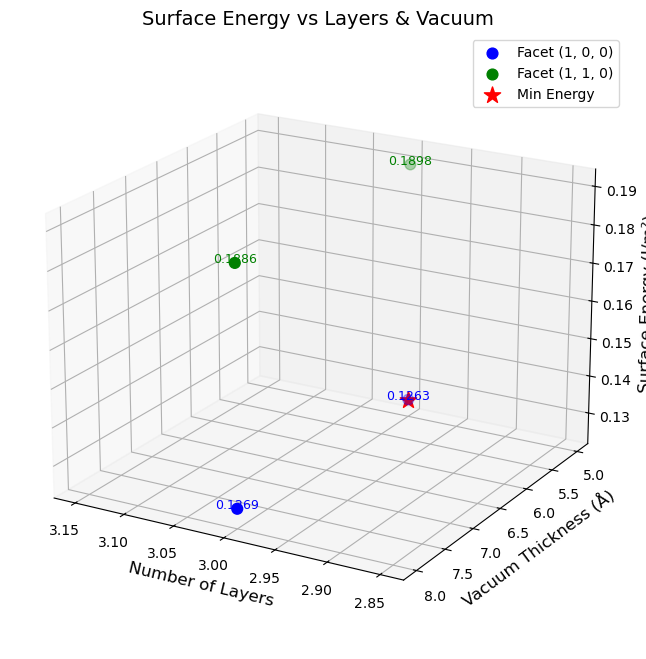

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 读取 CSV 数据
df = pd.read_csv('surface_energy_results.csv')

# 创建 3D 图
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Facet 颜色映射
colors = {
    "(1, 0, 0)": 'b',  # 蓝色
    "(1, 1, 0)": 'g',  # 绿色
    "(1, 1, 1)": 'orange'  # 橙色
}

# 记录最低 surface energy 及其对应点
min_gamma = df['surface_energy'].min()
min_point = df.loc[df['surface_energy'].idxmin()]

# 遍历不同 facet 并绘制散点
for facet in df['facet_name'].unique():
    subset = df[df['facet_name'] == facet]
    
    # 提取数据
    layers = subset['layers']
    vacuum = subset['vacuum']
    gamma = subset['surface_energy']
    
    # 画散点
    ax.scatter(layers, vacuum, gamma, label=f"Facet {facet}", color=colors[facet], s=60)

    # 标注 surface energy 值
    for x, y, z in zip(layers, vacuum, gamma):
        ax.text(x, y, z, f"{z:.4f}", fontsize=9, ha='center', color=colors[facet])

# 在最低 surface energy 处叠加红星
ax.scatter(min_point['layers'], min_point['vacuum'], min_point['surface_energy'], 
           color='red', s=150, marker='*', label='Min Energy')

# 设置坐标轴
ax.set_xlabel("Number of Layers", fontsize=12)
ax.set_ylabel("Vacuum Thickness (Å)", fontsize=12)
ax.set_zlabel("Surface Energy (J/m²)", fontsize=12)
ax.set_title("Surface Energy vs Layers & Vacuum", fontsize=14)

# 添加图例
ax.legend()

# 美化 3D 视角
ax.view_init(elev=20, azim=120)  # 调整视角

# 显示图像
plt.show()


In [2]:
#plot surface energy vs layers
import os
script_dir = os.getcwd()
result_dir = os.path.join(script_dir, 'result')
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

for facet in facets:
    for vacuum in vacuum_list:
        filtered_indices = [i for i, (lay, vac) in enumerate(all_params[facet]) if vac == vacuum]
        filtered_layers = [lay for i, (lay, vac) in enumerate(all_params[facet]) if vac == vacuum]
        filtered_gammas = [all_gammas[facet][i] for i in filtered_indices]

        plt.figure()
        plt.plot(filtered_layers, filtered_gammas, marker='o')
        plt.scatter(filtered_layers, filtered_gammas, color='red', marker='*')
        plt.text(filtered_layers, filtered_gammas, f'{filtered_gammas}', ha='left', va='bottom')
        plt.title(f'Surface Energy vs Layers for {facet} Facet (Vacuum = {vacuum} Å)')
        plt.xlabel('Layers')
        plt.ylabel('Surface Energy (J/m²)')
        plt.grid(True)
        plt.savefig(os.path.join(result_dir, f'task6_surface_energy_vs_layers_{facet}_vacuum_{vacuum}.png'))
        plt.close()

#plot surface energy vs vacuum
for facet in facets:
    for layers in layers_list:
        filtered_indices = [i for i, (lay, vac) in enumerate(all_params[facet]) if lay == layers]
        filtered_vacuum = [vac for i, (lay, vac) in enumerate(all_params[facet]) if lay == layers]
        filtered_gammas = [all_gammas[facet][i] for i in filtered_indices]
        plt.figure()
        plt.plot(filtered_vacuum, filtered_gammas, marker='o')
        plt.scatter(filtered_vacuum, filtered_gammas, color='red', marker='*')
        plt.text(filtered_vacuum, filtered_gammas, f'{filtered_gammas}', ha='left', va='bottom')
        plt.title(f'Surface Energy vs Vacuum for {facet} Facet (Layers = {layers})')
        plt.xlabel('Vacuum (Å)')
        plt.ylabel('Surface Energy (J/m²)')
        plt.grid(True)
        plt.savefig(os.path.join(result_dir, f'task6_surface_energy_vs_vacuum_{facet}_layers_{layers}.png'))
        plt.close()

TypeError: float() argument must be a string or a real number, not 'list'

Error in callback <function _draw_all_if_interactive at 0x11e700c20> (for post_execute), with arguments args (),kwargs {}:


TypeError: float() argument must be a string or a real number, not 'list'

TypeError: float() argument must be a string or a real number, not 'list'

<Figure size 640x480 with 1 Axes>